In [1]:
import pandas as pd
import networkx as nx
import tqdm
from causaldata import social_insure
from pgmpy.estimators.CITests import pillai_trace
from dowhy.causal_identifier import backdoor

df: pd.DataFrame = social_insure.load_pandas().data.dropna()

In [2]:
# Drop fields 'address'
df = df.drop(columns=['address'])

# From social insurance, take takeup_survey
takeup_survey = df['takeup_survey']

## Convert labels to categorical variables

In [3]:
categorical_variables = ['village']
for var in categorical_variables:
    df[var] = df[var].astype('category').cat.codes


# 2.1 Testing correlation / dependence between variables

100%|██████████| 12/12 [00:02<00:00,  4.52it/s]


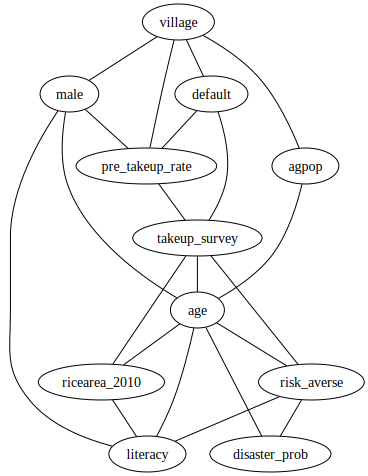

In [4]:
# For each other variable, calculate the p value of the correlation with takeup_survey
graph1: dict[str, dict[str, bool]] = {}

# Double for loop to compute pillai_trace between each pair of columns
for col1 in tqdm.tqdm(df.columns):
    graph1[col1] = {}
    for col2 in df.columns:
        if col1 == col2:
            continue
        graph1[col1][col2] = pillai_trace(col1, col2, Z=[], data=df, significance_level=0.05)

# Create a graph from the p values
G1 = nx.Graph()
for col1 in graph1:
    for col2 in graph1[col1]:
        p_value = graph1[col1][col2]
        if not p_value:
            G1.add_edge(col1, col2)


A = nx.nx_agraph.to_agraph(G1)
A.layout('dot')
A

As can be seen in the above image, the causal links calculated make sense. For example,
 - `age` and `disaster probability` have in no way any correlation.
 - `village` and `male` are uncorrelated.

# 2.2 Casual graph
As the true causal graph is unknown, we cooked something up which made sense.

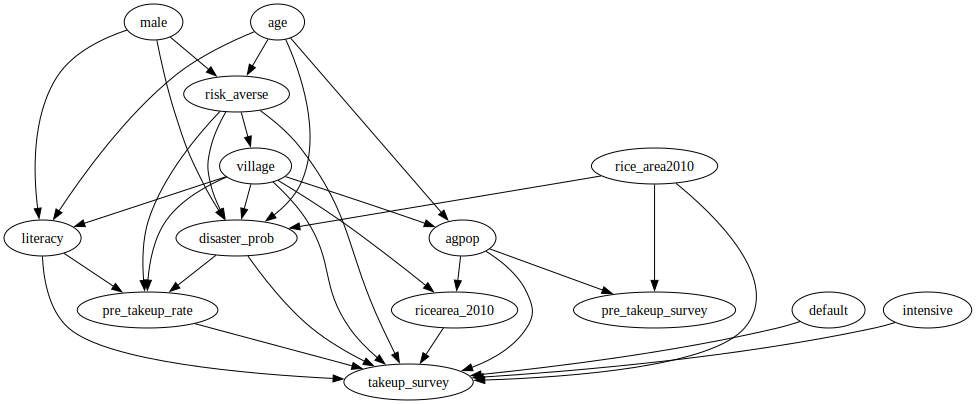

In [5]:
TG = nx.DiGraph()

TG.add_edges_from([
    ('default', 'takeup_survey'),

    ('intensive', 'takeup_survey'),
    
    ('pre_takeup_rate', 'takeup_survey'),
    
    ('risk_averse', 'pre_takeup_rate'),
    ('risk_averse', 'takeup_survey'),
    ('risk_averse', 'village'),
    ("risk_averse", "disaster_prob"), # disaster prob is perceived,

    ('disaster_prob', 'pre_takeup_rate'),
    ('disaster_prob', 'takeup_survey'),

    ('literacy', 'pre_takeup_rate'),
    ('literacy', 'takeup_survey'),

    ('village', 'pre_takeup_rate'),
    ('village', 'takeup_survey'),
    ('village', 'literacy'),
    ('village', 'ricearea_2010'),
    ('village', 'disaster_prob'),
    ("village", "agpop"), # certain villages might expect larger families
    
    ('age', 'agpop'),
    ("age", "literacy"), # older people -> less education (?)
    ("age", "risk_averse"), # older people more risk averse
    ("age", "disaster_prob"), # disaster prob is perceived, so older -> better intuition


    ("agpop", "ricearea_2010"), # larger homes -> more land
    ("agpop", "takeup_survey"), # more security wanted because of family size
    ("agpop", "pre_takeup_survey"), # same as previous

    ("male", "literacy"), # gender gaps in education
    ("male", "risk_averse"), # gender differences in risk attitudes
    ("male", "disaster_prob"), # disaster prob is perceived,

    ("rice_area2010", "disaster_prob"), # more land -> more chances for disaster
    ("rice_area2010", "takeup_survey"), # more land -> more at stake
    ("rice_area2010", "pre_takeup_survey"), # same as previous
    ('ricearea_2010', 'takeup_survey'),
])

A = nx.nx_agraph.to_agraph(TG)
A.layout('dot')
A

# 3. Backdoor, Frontdoor and Instrumental Variables Criteria

In [6]:
# Calculate all possible paths
all_paths = list(nx.all_simple_paths(TG, source='risk_averse', target='takeup_survey'))

### Backdoor Criterion

In [7]:
# First do backdoor criterion
bd = backdoor.Backdoor(TG, 'risk_averse', 'takeup_survey')

# Check for backdoors
bd_paths = [path for path in all_paths if bd.is_backdoor(path)]
for path in bd_paths:
    print("Backdoor path found:", path)

### Frontdoor Criterion

In [10]:
from dowhy.causal_identifier import identify_effect
from dowhy import CausalModel

model = CausalModel(
    data=df,
    treatment='risk_averse',
    outcome='takeup_survey',
    graph=TG
)

print(model.identify_effect())

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['risk_averse'] on outcome ['takeup_survey']
INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_identifier.auto_identifier:Number of general adjustment sets found: 1
INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                 
─────────────(E[takeup_survey|age,male])
d[riskₐᵥₑᵣₛₑ]                           
Estimand assumption 1, Unconfoundedness: If U→{risk_averse} and U→takeup_survey then P(takeup_survey|risk_averse,age,male,U) = P(takeup_survey|risk_averse,age,male)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
      d                                 
─────────────(E[takeup_survey|age,male])
d[riskₐᵥₑᵣₛₑ]                           
Estimand assumption 1, Unconfoundedness: If U→{risk_averse} and U→takeup_survey then P(takeup_survey|risk_averse,age,male,U) = P(takeup_survey|risk_averse,age,male)

